# Run model
This notebook implements a UNet neural network to perform segmentation on the training images.

In [1]:
import os
import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, merge, UpSampling2D, Convolution2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.optimizers import Adam
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation


import time
import pickle

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled


def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return K.mean(jac)


def jacc_coef_loss(y_true, y_pred):
    
    return -jacc_coef(y_true, y_pred)


def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return K.mean(jac)


def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef])

    return model


def history_plot(fit):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('jaccard coef vs epoch')
    plt.plot(fit.history['jacc_coef'], label='jacc_coef')
    plt.plot(fit.history['val_jacc_coef'], label='val_jacc_coef')
#     plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('cross entropy loss vs epoch')
    plt.plot(fit.history['loss'], label='loss')
    plt.plot(fit.history['val_loss'], label='val_loss')
#     plt.grid()

    plt.legend();
    
    
class prediction_history(keras.callbacks.Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(model.predict(X_val))
        
        
def generator(x_train, y_train, batch_size):

    # create empty arrays to contain batch of xs and ys
    x_batch = np.zeros_like(x_train)
    y_batch = np.zeros_like(y_train)

    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(x_train),1)
            x_batch = x_train[index]
            y_batch = y_train[index]

        yield x_batch, y_batch

### Load-in training/validation sets

In [3]:
X_train = pickle.load(open('../pickle_jar/X_train_r2_4000_V.p','rb'))
Y_train = pickle.load(open('../pickle_jar/Y_train_r2_4000_V.p','rb'))
X_val = pickle.load(open('../pickle_jar/X_val_r2_500_III.p','rb'))
Y_val = pickle.load(open('../pickle_jar/Y_val_r2_500_III.p','rb'))

In [4]:
# verify shape of sets
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(4000, 240, 240, 8)
(4000, 240, 240, 1)
(500, 240, 240, 8)
(500, 240, 240, 1)


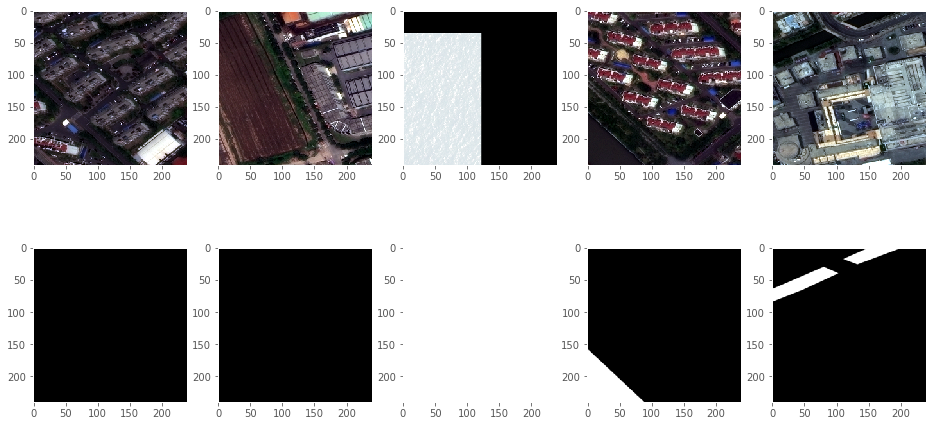

In [5]:
# View some images to verify training set
# plt.rc("image", cmap="binary") # use black/white palette for plotting
start = 0
fig, ax = plt.subplots(2,5, figsize=(16,8))
for i in range(0, 5):
#     plt.subplot(2,5,i+1-start)
    x = X_train[start + i]
    y = Y_train[start + i]
    ax[0,i].imshow(scale_bands(x[:,:,[4,2,1]]))
    ax[1,i].imshow(y[:, :, 0], cmap=plt.cm.gray, vmin=0, vmax=1)
#     plt.xticks(())
#     plt.yticks(())
    ax[0,i].grid()
    ax[1,i].grid()
# plt.tight_layout()
# print (Y_train[start:start+5])

### Implement model

In [6]:
# set network size params
N_CLASSES = 1 # water
N_CHANNEL = 8

# define metrics
smooth = 1.

NUM_EPOCHS = 75
INPUT_SIZE = 240

In [ ]:
# Define callback to save model checkpoints
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'), 
                                   monitor='loss', 
                                   save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5, 
                              patience=3, 
                              epsilon=0.002, 
                              cooldown=1)

# # Define rate scheduler callack (this is an alternative to ReduceLROnPlateau. There is no reason to use both.)
# schedule = lambda epoch_i: 0.01*np.power(0.97, i)
# schedule_lr = LearningRateScheduler(schedule)

# TensorBoard visualizations... this stuff is so freaking cool
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=True)

predictions=prediction_history()

lr = 1e-4
batch_size = 64
steps = 3000

# Train the model
model = get_unet(lr)

fit = model.fit_generator(generator(x_train=X_train, y_train=Y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, 
                    epochs=NUM_EPOCHS, 
                    callbacks=[model_checkpoint, reduce_lr, tensorboard, predictions],
                    validation_data=(X_val, Y_val))

Epoch 1/75
3000/3000 [==============================] - 302s - loss: 0.3916 - jacc_coef: 0.1438 - val_loss: 0.3099 - val_jacc_coef: 0.1838
Epoch 2/75
 323/3000 [==>...........................] - ETA: 242s - loss: 0.2973 - jacc_coef: 0.1935

In [ ]:
# pickle model
model.save('../pickle_jar/unet_XXIX_{:.3f}_{:.3f}'.format(fit.history['val_loss'][-1],
                                                        fit.history['val_jacc_coef'][-1]))

In [20]:
# save prediction history for a few images
img_28_preds = [predictions.predhis[i][28,:,:,0] for i in range(NUM_EPOCHS)]
img_74_preds = [predictions.predhis[i][74,:,:,0] for i in range(NUM_EPOCHS)]

img_28_set = [X_val[28], Y_val[28], img_28_preds]
img_74_set = [X_val[74], Y_val[74], img_74_preds]

In [21]:
pickle.dump(img_28_set, open('../pickle_jar/img_28_set_X.p','wb'))
pickle.dump(img_74_set, open('../pickle_jar/img_74_set_X.p','wb'))

### Inspect learning curves

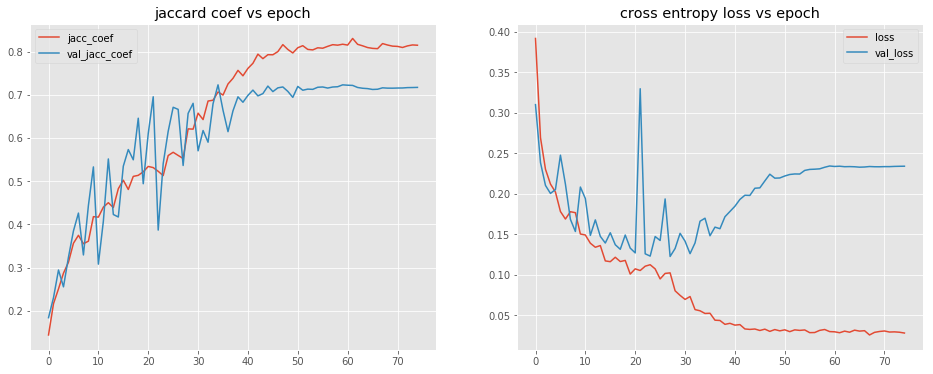

In [11]:
history_plot(fit)

### View predictions

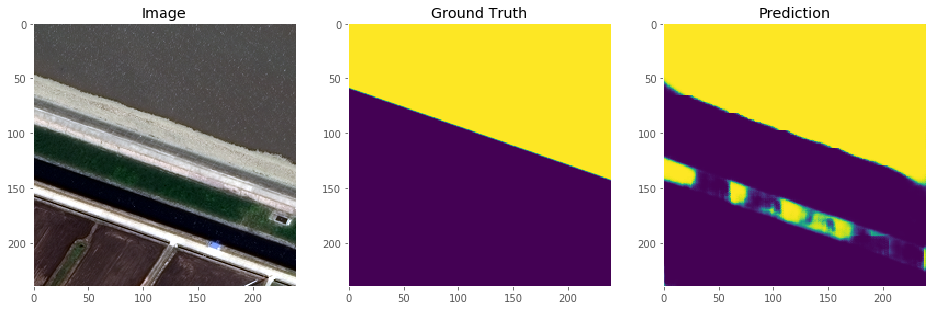

1/500
DONE


In [17]:
for i in range(Y_val.shape[0]):
    
    x = X_val[i]
    y = Y_val[i]

    # Pick out which target to look at
    CLASS_NO = 0
    targ = y[:, :, CLASS_NO]

    # Run the model on that sample
    pred = model.predict(X_val)[i, :, :, CLASS_NO]

    # Plot it
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,8))
    ax1.imshow(scale_bands(x[:,:,[4,2,1]])) # This index starts at 0, so I had to decrement
    ax2.imshow(targ, vmin=0, vmax=1)
    ax3.imshow(pred, vmin=0, vmax=1)

    ax1.set_title('Image')
    ax2.set_title('Ground Truth');
    ax3.set_title('Prediction');
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()
    print('{}/{}'.format(i + 1, Y_val.shape[0]))
    
    break
    
    time.sleep(1)
    display.clear_output(wait=True)

print('DONE')